# A/B testing

In [1]:
import pandas as pd
import statsmodels.stats.api as sms
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
import numpy as np
import scipy.stats as stats
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

### What is A/B testing?

### A/B Testing is important because:

### Steps to design an A/B Test

### Steps to implement an A/B Test

### Scenario for the study

#### 1. Designing of the experiment

#### 2. Collecting and preparing the data

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


##### Clean dataset

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


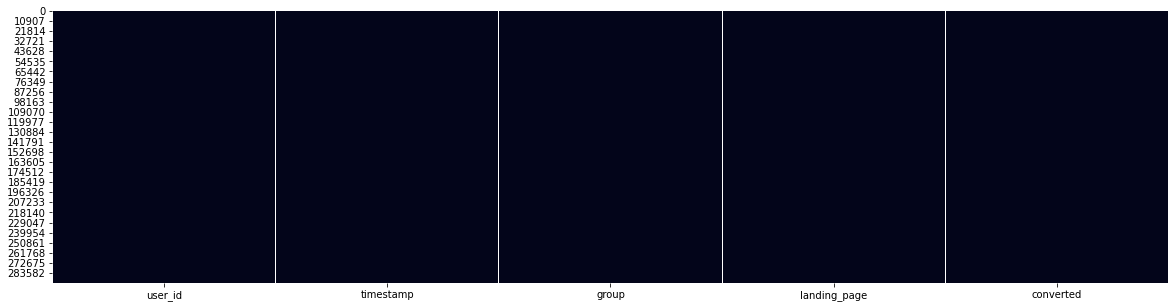

In [4]:
plt.figure(figsize=(20,5))
sns.heatmap(df.isnull(), cbar=False)
plt.show()

In [5]:
pd.crosstab(df['group'], df['landing_page'])

landing_page,new_page,old_page
group,,
control,1928,145274
treatment,145311,1965


In [6]:
df = df[(((df['group'] == 'control') & (df['landing_page'] == 'old_page')) | ((df['group'] == 'treatment') & (df['landing_page'] == 'new_page')))].reset_index(drop=True)
pd.crosstab(df['group'], df['landing_page'])

landing_page,new_page,old_page
group,,
control,0,145274
treatment,145311,0


In [7]:
df['user_id'][df['user_id'].duplicated()].count()

1

In [8]:
df[df['user_id'].duplicated()]

,user_id,timestamp,group,landing_page,converted
2862,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [9]:
df = df[~df['user_id'].duplicated()].reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290584 entries, 0 to 290583
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       290584 non-null  int64 
 1   timestamp     290584 non-null  object
 2   group         290584 non-null  object
 3   landing_page  290584 non-null  object
 4   converted     290584 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.1+ MB


In [10]:
print("Information about groups:")
print("-------------------------")
print("Users who saw old page Vs. users who saw new page: (%{}) {} - (%{}) {}\n".format(round((df[df['group'] == 'control'].shape[0]/ df.shape[0])*100,2), 
                                                                                     df[df['group'] == 'control'].shape[0],
                                                                                     round((df[df['group'] == 'treatment'].shape[0]/ df.shape[0])*100,2),
                                                                                     df[df['group'] == 'treatment'].shape[0]))
print("Number of control users who converted on old page:  (%{}) {}\n".format(round((df[df['group'] == 'control']['converted'].sum()/ df[df['group'] == 'control'].shape[0])*100,2),
                                                                            df[df['group'] == 'control']['converted'].sum()))
print("Number of treatment users who converted on new page:  (%{}) {}\n".format(round((df[df['group'] == 'treatment']['converted'].sum()/ df[df['group'] == 'treatment'].shape[0])*100,2),
                                                                            df[df['group'] == 'treatment']['converted'].sum()))


Information about groups:
-------------------------
Users who saw old page Vs. users who saw new page: (%49.99) 145274 - (%50.01) 145310

Number of control users who converted on old page:  (%12.04) 17489

Number of treatment users who converted on new page:  (%11.88) 17264



##### Check sample size

In [11]:
baseline_rate = df[df['group'] == 'control']['converted'].sum()/ df[df['group'] == 'control'].shape[0]
significant_rate = 0.01
effect_size = sms.proportion_effectsize(baseline_rate, baseline_rate + significant_rate)
required_sample = sms.NormalIndPower().solve_power(effect_size,
                                                  power=0.8,
                                                  alpha=0.05,
                                                  ratio=1)
print("Required sample size for the test by group: {}".format(round(required_sample)))

Required sample size for the test by group: 17209


In [12]:
required_sample = ceil(required_sample)
control_sample = df[df['group'] == 'control'].sample(n=required_sample, random_state=7)
control_sample

,user_id,timestamp,group,landing_page,converted
45147,890040,2017-01-11 12:26:34.602778,control,old_page,0
6826,830959,2017-01-08 13:23:53.884029,control,old_page,0
188829,802182,2017-01-15 06:13:23.109105,control,old_page,0
254426,751020,2017-01-08 20:31:50.527041,control,old_page,0
261077,854965,2017-01-03 04:04:00.981359,control,old_page,0
...,...,...,...,...,...
67709,715894,2017-01-04 22:30:23.571674,control,old_page,1
220855,768772,2017-01-07 10:29:32.828241,control,old_page,0
219400,689807,2017-01-23 21:29:24.889902,control,old_page,0
190120,847258,2017-01-15 19:18:14.748514,control,old_page,1


In [13]:
treat_sample = df[df['group'] == 'treatment'].sample(n=required_sample, random_state=7)
treat_sample

,user_id,timestamp,group,landing_page,converted
99928,832176,2017-01-06 16:11:33.307903,treatment,new_page,0
290129,927026,2017-01-06 11:18:41.830874,treatment,new_page,0
19341,795449,2017-01-16 01:59:38.396882,treatment,new_page,0
48407,773140,2017-01-15 14:26:40.131475,treatment,new_page,0
64393,823446,2017-01-10 01:12:57.065832,treatment,new_page,0
...,...,...,...,...,...
183682,686164,2017-01-18 16:22:09.625687,treatment,new_page,0
38910,819026,2017-01-14 11:29:52.191056,treatment,new_page,0
79504,822789,2017-01-09 11:44:08.236301,treatment,new_page,0
1674,928811,2017-01-05 21:19:39.878333,treatment,new_page,0


In [14]:
ab_test = pd.concat([control_sample, treat_sample]).reset_index(drop=True)
ab_test

,user_id,timestamp,group,landing_page,converted
0,890040,2017-01-11 12:26:34.602778,control,old_page,0
1,830959,2017-01-08 13:23:53.884029,control,old_page,0
2,802182,2017-01-15 06:13:23.109105,control,old_page,0
3,751020,2017-01-08 20:31:50.527041,control,old_page,0
4,854965,2017-01-03 04:04:00.981359,control,old_page,0
...,...,...,...,...,...
34413,686164,2017-01-18 16:22:09.625687,treatment,new_page,0
34414,819026,2017-01-14 11:29:52.191056,treatment,new_page,0
34415,822789,2017-01-09 11:44:08.236301,treatment,new_page,0
34416,928811,2017-01-05 21:19:39.878333,treatment,new_page,0


#### Basic statistics

In [15]:
conversion_rates = ab_test.groupby('group')['converted'].agg([np.mean,
                                                              np.std,
                                                              stats.sem])
conversion_rates.columns = ['conversion_rate', 'std_deviation', 'std_error']
conversion_rates.style.format('{:.3f}')

,conversion_rate,std_deviation,std_error
group,,,
control,0.124,0.330,0.003
treatment,0.123,0.329,0.003


Looks like the designs have the same performance. The old design performing a little better, 12.4% vs. 12.3% conversion rate.

#### Visualising the results

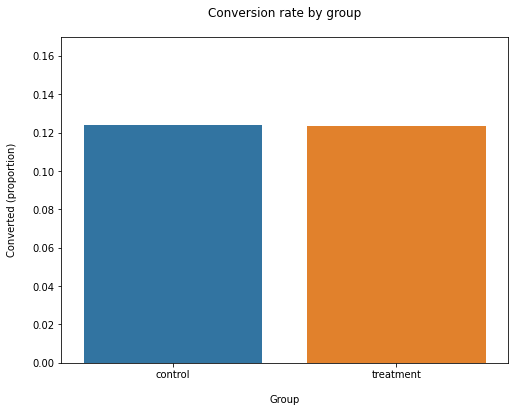

In [16]:
plt.figure(figsize=(8,6))
sns.barplot(x=ab_test['group'], y=ab_test['converted'], ci=False)
plt.ylim(0, 0.17)
plt.title('Conversion rate by group', pad=20)
plt.xlabel('Group', labelpad=15)
plt.ylabel('Converted (proportion)', labelpad=15);

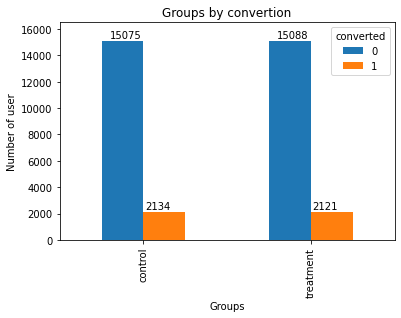

In [17]:
ab_test.groupby('group')['converted'].value_counts().unstack(level=1).plot.bar()
j = 0
for i in ab_test.groupby('group')['converted'].value_counts().unstack(level=1).values:
        plt.text(j - .2, i[0]+200, i[0], color='black')
        plt.text(j + .01, i[1]+200, i[1], color='black')
        j += 1        
plt.ylabel('Number of user')
plt.xlabel('Groups')
plt.title('Groups by convertion')
plt.ylim(0, 16500)
plt.show()

#### Testing the hypothesis

In [18]:
control_results = ab_test[ab_test['group'] == 'control']['converted']
treat_results = ab_test[ab_test['group'] == 'treatment']['converted']

control_samples = control_results.count()
treat_samples = treat_results.count()
successes = [control_results.sum(), treat_results.sum()]
nobs = [control_samples, treat_samples]

In [19]:
control_samples = control_results.count()
treat_samples = treat_results.count()
successes = [control_results.sum(), treat_results.sum()]
nobs = [control_samples, treat_samples]

In [20]:
z_stat, p_value = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

In [21]:
print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {p_value:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: 0.21
p-value: 0.831
ci 95% for control group: [0.119, 0.129]
ci 95% for treatment group: [0.118, 0.128]


#### Drawing conclusions

#### If we use all the data

In [22]:
control_sample = df[df['group'] == 'control'].sample(n=145274, random_state=7)
treat_sample = df[df['group'] == 'treatment'].sample(n=145274, random_state=7)
ab_test = pd.concat([control_sample, treat_sample]).reset_index(drop=True)

In [23]:
conversion_rates = ab_test.groupby('group')['converted'].agg([np.mean,
                                                              np.std,
                                                              stats.sem])
conversion_rates.columns = ['conversion_rate', 'std_deviation', 'std_error']
conversion_rates.style.format('{:.3f}')

,conversion_rate,std_deviation,std_error
group,,,
control,0.120,0.325,0.001
treatment,0.119,0.324,0.001


In [24]:
control_results = df[df['group'] == 'control']['converted']
treat_results = df[df['group'] == 'treatment']['converted']

control_samples = control_results.count()
treat_samples = treat_results.count()
successes = [control_results.sum(), treat_results.sum()]
nobs = [control_samples, treat_samples]

In [25]:
control_samples = control_results.count()
treat_samples = treat_results.count()
successes = [control_results.sum(), treat_results.sum()]
nobs = [control_samples, treat_samples]

In [26]:
z_stat, p_value = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

In [27]:
print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {p_value:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.4f}, {upper_treat:.4f}]')

z statistic: 1.31
p-value: 0.190
ci 95% for control group: [0.119, 0.122]
ci 95% for treatment group: [0.1171, 0.1205]
